In [1]:
from sklearn.datasets import make_regression
import tensorflow as tf

%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt

import numpy as np 

### Helper methods

In [2]:
def generate_linear_regression_problem(samples_num):
    bias = np.random.uniform(-5, 5)
    data_noise = np.random.uniform(4, 8)
    x_values, y_values = make_regression(n_samples=samples_num, n_features=1, noise=data_noise, 
                                         bias=bias)
    return x_values, y_values.reshape(-1, 1)

### Generate problem

In [3]:
samples_num = 100

In [4]:
x_values, y_values = generate_linear_regression_problem(samples_num)

- Presenting generated data

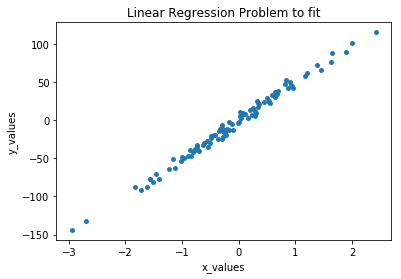

In [5]:
plt.scatter(x_values, y_values, s=15)
plt.title("Linear Regression Problem to fit")
plt.xlabel("x_values")
plt.ylabel("y_values")
plt.show()

### Tensorflow solution

- Reseting graph

In [6]:
tf.reset_default_graph()

- Helper constants

In [7]:
num_inputs = x_values.shape[1]
num_outputs = 1

- Building graph

In [8]:
with tf.name_scope("io-scope"):
    inputs_ = tf.placeholder(tf.float32, [None, num_inputs], name="inputs")
    targets_ = tf.placeholder(tf.float32, [None, num_outputs], name="targets")

with tf.name_scope("lr-scope"):
    learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")

with tf.name_scope("weights-scope"):
    weights = tf.Variable(tf.random_normal([num_inputs, 1]), name="weights")

with tf.name_scope("bias-scope"):
    bias = tf.Variable(tf.random_normal([num_outputs]), name="bias")

In [9]:
predictions = tf.add(tf.matmul(inputs_, weights), bias)

with tf.name_scope("MSE-scope"):
    mse = tf.reduce_sum(tf.pow(predictions - targets_, 2))/(2*samples_num)
    tf.summary.scalar("cost", mse)

optimizer = tf.train.GradientDescentOptimizer(learning_rate_).minimize(mse)

### Hyperparameters

In [10]:
epochs = 1500
learning_rate = 0.005

### Saver for saving & restoring model

In [11]:
MODEL_DIR = "./model/model.ckpt"

saver = tf.train.Saver([weights, bias])

### FileWrter for Tensorboard

In [12]:
TENSORBOARD_FILES_DIR = "./tensorboard" 
tensorboard_data = tf.summary.merge_all()

### Training

In [13]:
init = tf.global_variables_initializer()

Epoch: 050 cost= 703.57922 weights= [[ 10.80355358]] bias= [-1.13749552]
Epoch: 100 cost= 453.14764 weights= [[ 18.63664436]] bias= [-1.87733459]
Epoch: 150 cost= 294.30438 weights= [[ 24.8914814]] bias= [-2.26153374]
Epoch: 200 cost= 193.12599 weights= [[ 29.89113235]] bias= [-2.40746713]
Epoch: 250 cost= 128.41698 weights= [[ 33.89141846]] bias= [-2.39861751]
Epoch: 300 cost= 86.87269 weights= [[ 37.09518814]] bias= [-2.29372406]
Epoch: 350 cost= 60.10384 weights= [[ 39.66343689]] bias= [-2.1335566]
Epoch: 400 cost= 42.79712 weights= [[ 41.72407913]] bias= [-1.94591844]
Epoch: 450 cost= 31.57250 weights= [[ 43.37892151]] bias= [-1.74932396]
Epoch: 500 cost= 24.27163 weights= [[ 44.70896149]] bias= [-1.5556978]
Epoch: 550 cost= 19.51012 weights= [[ 45.77884674]] bias= [-1.37233996]
Epoch: 600 cost= 16.39724 weights= [[ 46.6401329]] bias= [-1.20335162]
Epoch: 650 cost= 14.35768 weights= [[ 47.33401108]] bias= [-1.05066276]
Epoch: 700 cost= 13.01867 weights= [[ 47.89343262]] bias= [-0.9

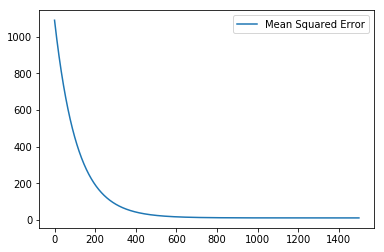

In [14]:
# container for train history
train = {"cost": []}

# start new session
with tf.Session() as sess:
    file_writer = tf.summary.FileWriter(TENSORBOARD_FILES_DIR, sess.graph)
    sess.run(init)

    for epoch in range(epochs):
        # train model and calculate loss
        _, summary, cost = sess.run([optimizer, tensorboard_data, mse], 
                                    feed_dict={inputs_: x_values, targets_: y_values, 
                                               learning_rate_: learning_rate})
        
        # save error for display
        train["cost"].append(cost)
        
        # save tensorboard data
        file_writer.add_summary(summary, epoch)
        
        # print model stats every 50 steps
        if (epoch + 1) % 50 == 0:
            print("Epoch:", "%03d" % (epoch + 1), "cost=", "{:.5f}".format(cost), 
                "weights=", sess.run(weights), "bias=", sess.run(bias))

    # save model to file
    save_path = saver.save(sess, MODEL_DIR)
    
    # print train history
    plt.plot(range(epochs), train["cost"], label="Mean Squared Error")
    plt.legend()
    plt.show()

### Tensorboard
- Full Tensorboard launch command: 

      tensorboard --logdir=<tensorboard_file_dir>

In [15]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [16]:
show_graph(tf.get_default_graph().as_graph_def())

### Reuse model

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


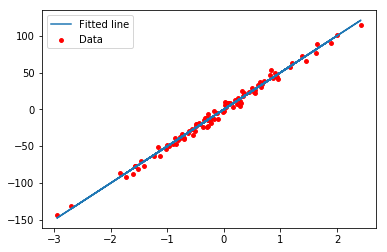

In [17]:
with tf.Session() as sess:
    # load trained model from .ckpt file
    saver.restore(sess, MODEL_DIR)
    
    # use model to fit data
    plt.scatter(x_values, y_values, c="r", s=15, label="Data")
    plt.plot(x_values, sess.run(weights) * x_values + sess.run(bias), label="Fitted line")
    plt.legend()
    plt.show()